# Titanic Passanger Survival Prediction

This notebook contains my efforts and thoughts for the Titanic: Machine Learning from Disaster [Kaggle](https://www.kaggle.com/c/titanic) competition. The aim is to explore different machine learning concepts rather than to find the optimal score. It is also a practice in making a well documented and easy to follow notebook.

### Covered topics
- Data preprocessing using Pandas
- Feature engineering
- Conventional ML models using scikit-learn
- Ensambles
- Hyperparameter tuning
- Neural network using Tensorflow

### Things for another day
- Visualizations
- Regularization
- Error Analysis

In [339]:
# Library imports
import math
from time import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import sklearn as sk
import sklearn.ensemble as ske
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [340]:
# Removes a warning in sklearn that will be fixed during an update mid 2018
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    le = sk.preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

## Reading the data
We will use widely used [Pandas](https://pandas.pydata.org/) to preprocess our data. We start with reading the data from .csv with read_csv(). When we have our dataframe in memory we can use head to take a first look at our data. 

In [341]:
df = pd.read_csv('C:/GitHub/kaggle/titanic/data/train.csv', sep=',', header=0)
print('Data size: ' + str(df.shape))
df.head(5)

Data size: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Analysing the data
Now we can inspect our features. We have 11 feauters, which we will call X, and 1 output (Survived), which we will call y. We can also see that we have 891 training examples. Now let's go over our features and try to reason over them. The most important thing is to find data that we think might affect the chance of survival for a passenger.

#### PassangerId
This is just used for indentification when scoring the predictions. It does not contain any ground truth about passengers and their survival and should therefore be removed before training.

#### Survived
This is what we want to predict, our output y. It should be split from the features and kept separate.

#### Pclass
The fare class of the passenger. Pclass = 1 is first class, Pclass = 2 is second class and Pclass = 3 is third class. This feature will likely affect survival. Things such people density and the distribution of [life boats](https://en.wikipedia.org/wiki/Lifeboats_of_the_RMS_Titanic) will likely vary amoung classes and play a part in survival.

#### Name
There are two things with the name that might be interesting in terms of surivival. The name might give us the gender of the passenger. We can however see that the gender is already provided in another feature, so there is no point in extracting it here. The second, and more interesting thing, is the title. The title can tell us the marital and sociatal status of a passenger.

#### Sex
["Women and children first"](https://en.wikipedia.org/wiki/Women_and_children_first) is famously associated with the Titanic. Therefore it is safe to assume that sex will play a large factor in survival.

#### Age
The same motivation as with sex can be applied as to why age would be important for survival.

#### SibSp
Number of siblings/spouses onboard. Probably will be a factor for survival since family members can help eachother.

#### Parch
Number of parents/children onboard. Very similar to the feature above.

#### Ticket
The tickets numbers seem to have some useful information in them. However, there seem to be little structure in the data. I decided to skip it to minimize initial effort. Might revise it later.

#### Fare
The price of the ticket. Will likely have similar factors as Pclass.

#### Embarked
Port of embarkation. Where C = Cherbourg, Q = Queenstown and S = Southampton. This should, at first glance, not play a big role in survival. However, it could possibly be a indirect factor and should not be dismissed without investigation.

### Data size
891 samples of data is on the low end for machine learning. It will mean that the model might be subseptible to overfitting. Overfitting is when to model specializes too much on the given dataset instead of learning a ground truth which that can help with predicting previously unseen data. It also means that it might be reasonable to chose simpler, conventional, machine learning models instead of the more data hungry neural networks.

#### Utils
Below are just some util functions that will later be used for feature engineering

In [342]:
# Checks and returns if a string contains one of a list of given substrings.
def substrings_in_string(whole, subs): 
    
    for x in subs:
        if x in str(whole): 
            return x
        
    return 'Unknown'

In [343]:
# Reducing data by combining decks with similar survival rates
def reduce_decks(x):
    
    reduced_decks = {
        "A": "AG",
        "B": "BDE",
        "C": "CF",
        "D": "BDE",
        "E": "BDE",
        "F": "CF",
        "G": "AG",
        "T": "UT",
        "Unknown": "UT"}
    
    return reduced_decks[x]

In [344]:
# Extract title from a name
def extract_title(full_name):
    
    full_name  = str(full_name)
    
    x = full_name.split(", ")
    x = x[1]
    x = x.split('.')
    title = x[0]
    
    return title

In [345]:
# Simplify titles into fewer more significant titles
def simplify_titles(x):
    
    titles = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Aristocrat",
    "Don": "Aristocrat",
    "Dona": "Aristocrat",
    "Sir" : "Aristocrat",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Aristocrat",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Aristocrat"
    }
    
    return titles[x]

## Data preprocessing and feature engineering
Data preprocessing and feature engineering go hand in hand and have the aim find the best possible data for a model. They are together probably the most important part for the success of a model, especially when the data size is small. It is not something that is performed once and then forgotten. Data should be revised and optimized in iterations together with models.

### Data preprocessing
Data preprocessing is when data is adjusted to be recieved by a model. The following processing is performed:
- Removing noise - Data not relevant for the prediction will make the model more noisy and should be removed.
- Missing values - Values that are missing are filled with mean of most common occuring value.
- Normalization - If data on different scales will serve as initial weights for the model. Therefor it is good to normalize the data and let the model find the weights be itself. A good normalization is to have all data on a magnititude of 0.0 - 1.0.
- Data discretation - Data that represents different categories (such as Pclass) can be represented as separate discreet features instead of quanties.

### Feature engineering
Feature engineering is when domain knowledge is applied to find new features that will be more useful for the model. The following techniques were used.
- Indicator Variables - Quantities can be divided into meaningful brackets. Example: Age can be divided into categories to find children since we know that they are more likely to live.
- Interaction Features - Features can sometimes be combined into something meaningful. Example: SibSp and Parch can be combined to find the family size.
- Grouping sparse data - Categorical data that has low occurence can be grouped into larger meaningful categories.


In [346]:
def preprocess_dataframe(df, prediction_data=False, print_info=False):
    # Age has missing values which is replaced with average
    # Might also consider dividing age into classes of age brackets
    df['Age'].fillna((df['Age'].mean()), inplace = True)
    df['Fare'].fillna((df['Fare'].mean()), inplace = True)
    
    # Encode sex into binary (0 = male, 1 = female)
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
    
    # Use the prefix in cabin to find the deck of the cabin
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck' ]= df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    df['Deck' ]= df['Deck'].map(lambda x: reduce_decks(x))
    
    # Calculate family size by combining SibSp and Parch
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # Divide age into useful brackets
    df['Child'] = df['Age'].apply(lambda x: 1 if x <= 12 else 0)

    """
    # Extract and process titles
    df['Title']= df['Name'].map(lambda x: extract_title(x))
    if not prediction_data:
        unique_titles = df['Title'].unique()
        survival_by_title = df.groupby('Title').mean()['Survived']
    
    df['Title']= df['Title'].map(lambda x: simplify_titles(x))
    if not prediction_data:
        unique_titles_simplified = df['Title'].unique()
        survival_by_title_simplified = df.groupby('Title').mean()['Survived']
    """
    
    # Gather info on the significance of these classes for survival
    # Class was, as expected, significance for surival with the rates (1st - 63%, 2nd - 47%, 3rd - 24%)
    # Embarked was suprisingly significant, C - Cherbourg had 55% surivial rate when the mean was just 38%
    if not prediction_data:
        survival_by_plcass = df.groupby('Pclass').mean()['Survived']
        survival_by_deck = df.groupby('Deck').mean()['Survived']
        survival_by_embark = df.groupby('Embarked').mean()['Survived']
        survival_by_family = df.groupby('FamilySize').mean()['Survived']
        survival_by_child = df.groupby('Child').mean()['Survived']
    
    # Split classes with one hot encoding
    # Pclass   - splits into (1 = Pclass_1, 2 = Pclass_2, 3 = Pclass_3)
    # Embarked - splits into (C = Embarked_C, Q = Embarked_Q, S = Embarked_S)
    # Deck - splits into decks with letters
    df = pd.get_dummies(df, columns = ['Pclass', 'Embarked', 'Deck']) #, 'Title'])

    # Drop columns with data deemed not relevant for learning
    # Name     - Gender already has its' own column. Only thing that might be interesting here is the title
    # Ticket   - Ticket does not really say much, price and class are already included which says the most
    # Cabin    - Replaced by Deck
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'SibSp', 'Parch'], axis=1)
    
    """
    # Deck_T is not present in the train set and must be inserted for uniformity
    if prediction_data:
        m = df.shape[0]
        df['Deck_T'] = pd.Series(np.zeros(m, dtype=int), index=df.index)
    """
    
    # Normalize the data
    norm_vals = ['Fare', 'FamilySize']
    df[norm_vals] = (df[norm_vals] - df[norm_vals].min())/(df[norm_vals].max() - df[norm_vals].min())
    
    # Look at interesting metrics to find information about the preprocessing/feature engineering
    if print_info:
        if not prediction_data:
            print('--------------------------------------------------------------------------------------')
            print('SURVIVAL RATE')
            print('--------------------------------------------------------------------------------------')
            print('Overall survival rate: ' + str(df['Survived'].mean()))
            print()
            print(survival_by_plcass.sort_values(ascending=False))
            print()
            print(survival_by_embark.sort_values(ascending=False))
            print()
            print(survival_by_deck.sort_values(ascending=False))
            print()
            """
            print(survival_by_title.sort_values(ascending=False))
            print()
            print(survival_by_title_simplified.sort_values(ascending=False))
            print()
            """
            print(survival_by_family.sort_values(ascending=False))
            print()
            print(survival_by_child.sort_values(ascending=False))
        """
        print('--------------------------------------------------------------------------------------')
        print('TITLES')
        print('--------------------------------------------------------------------------------------')
        print('All titels: ')
        print(unique_titles)
        print()
        print('Simplied titels: ')
        print(unique_titles_simplified)
        """
        print('--------------------------------------------------------------------------------------')
        print('SUMS')
        print('--------------------------------------------------------------------------------------')
        print(df.sum())
        print('--------------------------------------------------------------------------------------')
        print('DATA INFO')
        print('--------------------------------------------------------------------------------------')
        print(df.info())
        print('--------------------------------------------------------------------------------------')
        print('MISSING VALUES')
        print('--------------------------------------------------------------------------------------')
        print(df.isnull().sum())
        print('--------------------------------------------------------------------------------------')
        print('CORRELATIONS')
        print('--------------------------------------------------------------------------------------')
        print(df.corr())
        print('--------------------------------------------------------------------------------------')

    return df

## Model validation
To score the model it is important that the scoring is not performed on data that also has been used to train the model. Otherwise the evaluation will be overly optimistic but the performance on independant data will most likely perform much worse. The solution is to exclude a fraction of the data during training so that it can later be used for evaluation. This set is usually called the cross validation set.

Validation does however don't stop after training. And every time data has been used to make a decision then new data has to be used to evaluate how well that decision will hold up on new data. A best practice is to further divide the data into train/test/cross validation.

- Train set - Data used to train the model
- Cross validation - Data used for finding deciding between different models and hyperparamteres
- Test - Data used to make a final evaluation on how the model will perform on unseen data

In this competition the test set is already set aside by default, so only a simply train/validation split is performed.  

In [347]:
# Split data into train/validation set
def split_data(df):
    df_train = df.sample(frac = 0.8, random_state = 42)
    df_val = df.drop(df_train.index)  
    
    X_train = df_train.drop(['Survived'], axis=1).values
    y_train = df_train['Survived'].values
    
    X_val = df_val.drop(['Survived'], axis=1).values
    y_val = df_val['Survived'].values
    
    return X_train, y_train, X_val, y_val

In [348]:
df_processed = preprocess_dataframe(df, False, True)

X_train, y_train, X_val, y_val = split_data(df_processed)

print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

df_processed.head(5)

--------------------------------------------------------------------------------------
SURVIVAL RATE
--------------------------------------------------------------------------------------
Overall survival rate: 0.3838383838383838

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Deck
BDE    0.752212
CF     0.591549
AG     0.473684
UT     0.299419
Name: Survived, dtype: float64

FamilySize
3     0.724138
2     0.578431
1     0.552795
6     0.333333
0     0.303538
4     0.200000
5     0.136364
10    0.000000
7     0.000000
Name: Survived, dtype: float64

Child
1    0.579710
0    0.367397
Name: Survived, dtype: float64
--------------------------------------------------------------------------------------
SUMS
--------------------------------------------------------------------------------------
Survived      342.000000
Sex           314.000000
Fare           56.006859
FamilyS

,Survived,Sex,Fare,FamilySize,Child,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Deck_AG,Deck_BDE,Deck_CF,Deck_UT
0,0,0,0.014151,0.1,0,0,0,1,0,0,1,0,0,0,1
1,1,1,0.139136,0.1,0,1,0,0,1,0,0,0,0,1,0
2,1,1,0.015469,0.0,0,0,0,1,0,0,1,0,0,0,1
3,1,1,0.103644,0.1,0,1,0,0,0,0,1,0,0,1,0
4,0,0,0.015713,0.0,0,0,0,1,0,0,1,0,0,0,1


## Conventional Machine Learning Models
Today the hype is all neural networks, but they are not strictly better and it is often better to start with conventional machine learning algorithms. They are faster to implement and can often give a better result. Neural networks are notouriously heavy on computation and usually require lots of data before they outperform conventional algorithms.

In our case we have a very small training set, only 891 samples. So starting with conventional algorithms definately feels like the right choice. The strategy here will be to cast a wide net and try a wide variety of algorithms that can perform classification and then narrow it down to those who perform the best.

To implement the models we use scikit-learn, which is more or less the defacto framework for conventional ML. All classifiers used here are not really top candidates, but since scikit-learn makes it so easy to implement, we will still use quite a few just to learn. The algorithms we will use are:
- Decision tree
- Random forest
- Gradient boosting
- Logistic regression
- Support vector machine
- Naive Bayes
- K-Nearest Neighbors

### Decision Tree 
[Decision Tree](http://scikit-learn.org/stable/modules/tree.html) is a simple algorithm. It builds a tree of nested if-then-else statements based on the input features in order to make a prediction. It is generally weak to overfitting when the ratio of data/features is low, which unfortunately is our case.  

In [349]:
def decision_tree_clf(X_train, y_train, X_val, y_val):
    
    dt_clf = sk.tree.DecisionTreeClassifier(max_depth=20)
    dt_clf.fit (X_train, y_train)
    print(dt_clf.score (X_val, y_val))
    
    return dt_clf

In [350]:
dt_clf = decision_tree_clf(X_train, y_train, X_val, y_val)

0.8089887640449438


### Random Forest
[Random forest](http://scikit-learn.org/stable/modules/tree.html) is an ensamble algorithms. That means that it combines more than one instance of one or more algorithms in order to make a prediction. Random forest divides the data into smaller subsets and trains a decision tree on each set which is then averaged to make the final prediction. This helps counteract the overfitting that is seen in decision trees and is generally better.

In [351]:
def random_forest_clf(X_train, y_train, X_val, y_val):

    rf_clf = ske.RandomForestClassifier(n_estimators=50)
    rf_clf.fit (X_train, y_train)
    print(rf_clf.score (X_val, y_val))
    
    return rf_clf

In [352]:
rf_clf = random_forest_clf(X_train, y_train, X_val, y_val)

0.8202247191011236


### Gradient Boosting 
[Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) is another example of ensamble algorithms. It is a bit more involved than random forest and is not easy to summerize. You can say that it iteratively adds weaker models together weights them based on accuracy in order to output as one strong model.

In [353]:
def gradient_boosting_clf(X_train, y_train, X_val, y_val):
    
    gb_clf = ske.GradientBoostingClassifier(n_estimators=50)
    gb_clf.fit (X_train, y_train)
    print(gb_clf.score (X_val, y_val))
    
    return gb_clf

In [354]:
gb_clf = gradient_boosting_clf(X_train, y_train, X_val, y_val) 

0.8314606741573034


### Logistic Regression
[Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is an algorithm where a linear boundary is created that divides the positive and negative predictions. 

In [355]:
def logistic_regression_clf(X_train, y_train, X_val, y_val):
    
    lr_clf = LogisticRegression()
    lr_clf.fit (X_train, y_train)
    print(lr_clf.score (X_val, y_val))
    
    return lr_clf

In [356]:
lr_clf = logistic_regression_clf(X_train, y_train, X_val, y_val)

0.8314606741573034


### Support Vector Machines
[Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html) are similar to similar to logistic regression in the way that they also form a linear boundry to make predictions. The main difference is that SVMs find the samples hardest to classify, called the support vectors, and then finds the optimal boundery between them. SVMs are generally seen has a competitive algorithm that performs well on a variety of problems.

In [357]:
def support_vector_machine_clf(X_train, y_train, X_val, y_val):
    
    svm_clf = sk.svm.SVC(probability=True)
    svm_clf.fit (X_train, y_train)
    print(svm_clf.score (X_val, y_val))
    
    return svm_clf

In [358]:
svm_clf = support_vector_machine_clf(X_train, y_train, X_val, y_val) 

0.8089887640449438


### Naive Bayes
Naive bayes are a collection algorithms based on [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). What they have incommon is that they make the naive assumption that all features are independent of each other. The features are then given a probability which is then combined for the final output. The algorithm used here is [Gaussian Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).

In [359]:
def naive_bayes_clf(X_train, y_train, X_val, y_val):
    
    nb_clf = GaussianNB()
    nb_clf.fit (X_train, y_train)
    print(nb_clf.score (X_val, y_val))
    
    return nb_clf

In [360]:
nb_clf = naive_bayes_clf(X_train, y_train, X_val, y_val)

0.702247191011236


### K-Nearest Neighbor
[K-Nearest Neighbor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) is one of the simpler algorithms. A prediction is made by finding the classification of the k most similar training examples (neighbors). They are then counted as votes as to how new data should be classified.

In [361]:
def k_neighbors_clf(X_train, y_train, X_val, y_val):
    
    knn_clf = KNeighborsClassifier(n_neighbors=6)
    knn_clf.fit (X_train, y_train)
    print(knn_clf.score (X_val, y_val))
    
    return knn_clf

In [362]:
knn_clf = k_neighbors_clf(X_train, y_train, X_val, y_val)

0.848314606741573


### Ensamble Vote
We have already used two ensamble algorithms, random forest and gradient boosting. What separates [this ensamble](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) is that, unlike the previous, it does not use it's own algorithm to make predictions. Instead it uses a collective of other algorithms which then cast votes to decide on a classification.

Ensambles are used because they can reduce overfitting by having a regularizing effect. It is not necessary to use different algorithms, sometimes you use it on identical models that have been trained seperately. Just make sure that the model has a random element to them that can be varied for each model. You don't want a vote where everyone votes the same. 

In [363]:
def ensamble_voting_clf(clfs, X_train, y_train, X_val, y_val, cv=20, score_individually=False):
    
    e_clf = ske.VotingClassifier(estimators=clfs, voting='hard') # Hard voting where majority rules
    e_clf.fit (X_train, y_train)
    
    if score_individually:
        for label, clf in clfs:
            scores = cross_val_score(clf, X_val, y_val, cv=cv, scoring='accuracy')
            print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))    
    
    scores = cross_val_score(e_clf, X_val, y_val, cv=cv, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Voting Ensamble')) 
    
    return e_clf    

#### Building The Ensamble
Here we will use all our algorithms for the vote. For optimal performance this might not be the wisest choice. For instance there is little point in keeping the decision tree since it is already included in random forest. But we will also use this to compare our different models performance on the validation. Noteworthy is that we will use ensambles in an ensamble, creating ensambleception.

In [311]:
clfs = ([('Decision Tree', dt_clf), ('Random Forest', rf_clf), ('Gradiant Boosting', gb_clf), 
         ('Logistic Regression', lr_clf), ('SVM', svm_clf), ('Naive Bayes', nb_clf), ('K-Nearest', knn_clf)])

e_clf = ensamble_voting_clf(clfs, X_train, y_train, X_val, y_val, score_individually=True)

Accuracy: 0.82 (+/- 0.13) [Decision Tree]
Accuracy: 0.82 (+/- 0.11) [Random Forest]
Accuracy: 0.84 (+/- 0.12) [Gradiant Boosting]
Accuracy: 0.83 (+/- 0.11) [Logistic Regression]
Accuracy: 0.80 (+/- 0.10) [SVM]
Accuracy: 0.70 (+/- 0.10) [Naive Bayes]
Accuracy: 0.81 (+/- 0.13) [K-Nearest]
Accuracy: 0.83 (+/- 0.10) [Voting Ensamble]


## Prediction
Now that we have our models fully trained we can move on to prediction on the test set. From the validation summary on our ensamble we see that we have similar performance on all algorithms except Naive Bayes which got horrible results. But we won't know which one will be best with out trying them out.

Side note: Remember that Naive Bayes assumes that our features are independent. So for Naive Bayes to work better we should probably be more focused on eliminating/combining highly correlated features such as Pclass and Fare.

In [364]:
def predict(df, clf, export_path):
    """
    Description:
    Makes predictions X -> y and exports to csv

    Arguments:
    df -- Data to predict from, pandas DataFrame
    clf -- classifier, Classifier, sklearn classifier object
    export_path -- Path and name of file, String
        
    Returns:
    df_pred -- prediction, pandas DataFrame
    """
    
    # Extract Ids
    y1 = df['PassengerId'].values
    
    # Make predictions
    df_process = preprocess_dataframe(df, prediction_data=True, print_info=False)
    X = df_process.values
    y2 = clf.predict(X)
    
    # Combine ids and predictions
    y = np.column_stack((y1, y2))
    
    # Restore pandas df
    df_pred = pd.DataFrame(y)
    df_pred.columns = ["PassengerId", "Survived"]
    
    # Export
    df_pred.to_csv(export_path, sep=',', index=False)
    
    return df_pred

In [365]:
df_test = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
df_test = predict(df_test, svm_clf, 'C:/GitHub/kaggle/titanic/predictions/predictions_svm.csv')
df_test.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Hyperparameters
Hyperparameters are the parameters in a model that are not found during training/fitting. An example is setting a max depth on a decision tree. These parameters still play a role in performance and is therefore a subject for optimization. This can be done by hand but usually it is best to automate it. There are two main ways of doing it, and we will try them both. 

#### Reporting
First we build a report model that can tell us the results of our automated hypermeter tuning candidates.

In [366]:
def report(results, n_top=1):
    
    for i in range(1, n_top + 1):
        
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        
        for candidate in candidates:
            
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(
                results['params'][candidate]))
            print("")

### Random Search
Random search is the first method for automatically finding good candidates of hyperparameters. It works by providing the search with a distribution of values for the hyperparameters. Then the search tests random sets of values within the given distribution over and over again. The test are then evalutated using an internal cross validation in order to rank them individually.  

In [367]:
def random_search_hyperparameters(clf, hyper_param, X_train, y_train, X_val, y_val, print_result=False):
    
    # Run randomized search
    n_iter_search = 50
    rnd_clf = RandomizedSearchCV(clf, param_distributions=hyper_param, n_iter=n_iter_search)

    start = time()
    rnd_clf.fit(X_train, y_train)
    
    # Print metrics 
    if print_result:
        
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
        print()
        report(rnd_clf.cv_results_)
        y_act, y_pred = y_val, clf.predict(X_val)
        scores = cross_val_score(clf, X_val, y_val, cv=20, scoring='accuracy')
        print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        print()
        print(classification_report(y_act, y_pred))
       
    return rnd_clf.best_estimator_ 

### Grid Search
Grid search works in a similar way to random search. The main difference is that it uses a more systematic approach. Instead of a distribution it uses a grid of all the values that should be tested. Then it uses bruteforce to test and validate every possible combination in that grid.

In [368]:
def grid_search_hyperparameters(clf, hyper_param, X_train, y_train, X_val, y_val, print_result=False):
    
    # Run grid search
    grid_clf = GridSearchCV(clf, param_grid=hyper_param)
    
    start = time()
    grid_clf.fit(X_train, y_train)
    
    # Print metrics 
    if print_result:
        
        print("GridSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), len(grid_clf.cv_results_["rank_test_score"])))
        print()
        report(grid_clf.cv_results_)
        y_act, y_pred = y_val, clf.predict(X_val)
        scores = cross_val_score(clf, X_val, y_val, cv=20, scoring='accuracy')
        print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
        print()
        print(classification_report(y_act, y_pred))
    
    return grid_clf.best_estimator_

### Optimizing The Models
Hyperparameter tuning is where computing can start be a bit more heavy even for conventional machine learning algorithms. I found that the best results in my earlier predictions on the test set were usually made by Random Forest or SVM models. From now on I will focus on them.

The method of finding the best parameters will be to start with wide ranges which then can be narrowed down with increased resolution. The initial values will be values that I have seen other people use. For grid search a good way of finding values is to increase the parameter with a factor ~3 for each step, i.e. [1, 3, 10, 30, 100].

In [319]:
# specify parameters and distributions to sample from
hyper_param = {"max_depth": [3, None],
               "max_features": stats.randint(3, X_train.shape[1]),
               "min_samples_split": stats.randint(2, 11),
               "min_samples_leaf": stats.randint(1, 11),
               "bootstrap": [True, False],
               "criterion": ["gini", "entropy"]}

rf_rnd_clf = random_search_hyperparameters(rf_clf, hyper_param, X_train, y_train, X_val, y_val, True)

RandomizedSearchCV took 22.74 seconds for 50 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.830 (std: 0.012)
Parameters: {'min_samples_split': 2, 'max_features': 13, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6}

Validation Accuracy: 0.85 (+/- 0.11)

             precision    recall  f1-score   support

          0       0.86      0.86      0.86       113
          1       0.75      0.75      0.75        65

avg / total       0.82      0.82      0.82       178



In [369]:
# use a full grid over all parameters
hyper_param = {"max_depth": [3, None],
               "max_features": [3, 10, X_train.shape[1]],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "criterion": ["gini", "entropy"]}

rf_grid_clf = grid_search_hyperparameters(rf_clf, hyper_param, X_train, y_train, X_val, y_val, True)

GridSearchCV took 129.37 seconds for 216 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.820 (std: 0.005)
Parameters: {'min_samples_split': 2, 'max_features': 14, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}

Validation Accuracy: 0.82 (+/- 0.09)

             precision    recall  f1-score   support

          0       0.86      0.85      0.86       113
          1       0.75      0.77      0.76        65

avg / total       0.82      0.82      0.82       178



In [321]:
# specify parameters and distributions to sample from
hyper_param = {'C': stats.randint(10, 1000),
               'gamma' : stats.uniform(0.001, 1),
               'kernel': ['rbf']}

svm_rnd_clf = random_search_hyperparameters(svm_clf, hyper_param, X_train, y_train, X_val, y_val, True)

RandomizedSearchCV took 25.72 seconds for 50 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.823 (std: 0.004)
Parameters: {'C': 174, 'gamma': 0.007983889561916313, 'kernel': 'rbf'}

Validation Accuracy: 0.80 (+/- 0.10)

             precision    recall  f1-score   support

          0       0.85      0.87      0.86       113
          1       0.76      0.74      0.75        65

avg / total       0.82      0.82      0.82       178



In [370]:
# use a full grid over all parameters
hyper_param = {'C': [1, 3, 10, 100, 3000, 1000], 
               'gamma' : [0.001,0.003, 0.01, 0.1, 1], 
               'kernel': ['rbf']}

svm_grid_clf = grid_search_hyperparameters(svm_clf, hyper_param, X_train, y_train, X_val, y_val, True)

GridSearchCV took 13.78 seconds for 30 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.819 (std: 0.006)
Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.819 (std: 0.013)
Parameters: {'C': 3000, 'gamma': 0.003, 'kernel': 'rbf'}

Validation Accuracy: 0.81 (+/- 0.10)

             precision    recall  f1-score   support

          0       0.84      0.87      0.85       113
          1       0.75      0.71      0.73        65

avg / total       0.81      0.81      0.81       178



## Making Final Predictions
Now we have completed all the steps necessary to make our final predictions. Looking at the output of our parameter searches we seem that the results seem to be similar for both random and grid search for both algorithms. They basically do the same things, and which one to use is mostly a matter of preference even though there is some debate about the subject. 

In [376]:
df_test = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
df_test = predict(df_test, svm_grid_clf, 'C:/GitHub/kaggle/titanic/predictions/predictions_tuned_svm.csv')
df_test.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [83]:
def create_model(paramters):
    
    num_features = parameters['num_features']
    X = tf.placeholder(tf.float32, [None, num_features], name='X')
    y = tf.placeholder(tf.float32, [None, 1], name='y')

    layers_dim = paramters['layers_dim']
    
    fc = tf.contrib.layers.stack(X, tf.contrib.layers.fully_connected, layers_dim)
    Z = tf.contrib.layers.fully_connected(fc, 1, activation_fn=None, scope='Z')
    
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=y, name='Loss')
    cost = tf.reduce_mean(loss, name='Cost')
    
    learning_rate = parameters['learning_rate']
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    prediction = tf.round(tf.sigmoid(Z))
    correct_prediction = tf.equal(prediction, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model = {'X': X, 'y': y, 'Z': Z, 'cost': cost,
             'train_op': train_op, 'prediction': prediction, 'accuracy': accuracy}
    
    return model

In [84]:
def random_mini_batches(X_train, Y_train, mini_batch_size = 32, seed = 0):
 
    # Shuffle with identical seed to get same shuffle in both X and Y
    np.random.seed(seed)
    X_train = np.random.permutation(X_train)
    
    np.random.seed(seed)
    Y_train = np.random.permutation(Y_train)
    
    m = X_train.shape[0]
    num_batches = int(m / mini_batch_size)
    
    # Split data into smaller batches for ready for stochastic gradient descent
    minibatches_X = np.array_split(X_train, num_batches)
    minibatches_Y = np.array_split(Y_train, num_batches)
    
    minibatches = zip(minibatches_X, minibatches_Y)
    
    return minibatches

In [85]:
def train_model(parameters, model):
    
    num_epochs = parameters['num_epochs']
    minibatch_size = parameters['minibatch_size']
    X_train = parameters['X_train']
    y_train = parameters['y_train']
    
    
    train_size = X_train.shape[0]
    saver = tf.train.Saver()
    epoch_list = []
    cost_list = []
    
    with tf.Session() as sess:
        
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(train_size / minibatch_size)
            minibatches = random_mini_batches(X_train, y_train, minibatch_size)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_y) = minibatch
                minibatch_y = np.reshape(minibatch_y, (minibatch_X.shape[0], 1))
                feed_dict = {model['X'] : minibatch_X, model['y'] : minibatch_y}

                _model ,minibatch_cost = sess.run([model['train_op'], model['cost']], feed_dict= feed_dict)
                epoch_cost += minibatch_cost / num_minibatches
            
            if parameters['print'] and (epoch % parameters['print_freq'] == 0):
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
            if parameters['save_cost'] and (epoch % parameters['save_cost_freq'] == 0):
                epoch_list.append(epoch)
                cost_list.append(epoch_cost)
                
        saver.save(sess, parameters['save_path'])
        
    return {'epoch_list': epoch_list, 'cost_list' : cost_list}

In [86]:
parameters = {}

# set model parameters
parameters['X_train'] = X_train
parameters['y_train'] = y_train
parameters['X_val'] = X_val
parameters['y_val'] = y_val
parameters['X_test'] = pd.read_csv('C:/GitHub/kaggle/titanic/data/test.csv', sep=',', header=0)
parameters['PassangerId'] = pd.DataFrame(parameters['X_test']['PassengerId'], columns=['PassengerId'])
parameters['layers_dim'] = [14]
parameters['num_features'] = X_train.shape[1]
parameters['layers_dim'] = [14]
parameters['learning_rate'] = 0.01

# set train parameters (hyper parameter)
parameters['num_epochs'] = 3000
parameters['minibatch_size'] = 20

# set option parameters
parameters['model_name'] = 'nn_clf'
parameters['save_path'] = 'C:/GitHub/kaggle/titanic/models/' + parameters['model_name']
parameters['print'] = True
parameters['print_freq'] = 500
parameters['save_cost'] = True
parameters['save_cost_freq'] = 10

In [87]:
with tf.Graph().as_default():
    model = create_model(parameters)
    plot_data = train_model(parameters, model)

Instructions for updating:
Use the retry module or similar alternatives.
Cost after epoch 0: 0.583991
Cost after epoch 500: 0.338940
Cost after epoch 1000: 0.322726
Cost after epoch 1500: 0.319052
Cost after epoch 2000: 0.316830
Cost after epoch 2500: 0.314657


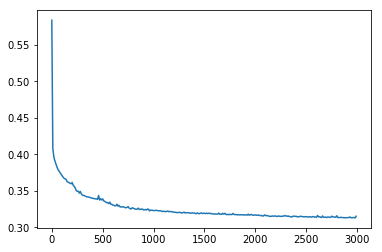

In [88]:
print
if parameters['save_cost']:
    plt.plot(plot_data['epoch_list'], plot_data['cost_list'])

In [89]:
def evaluate(parameters, model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['save_path'])
        print ("Train Accuracy:", model['accuracy'].eval({model['X']: X_train, 
                                                          model['y']: np.reshape(y_train, (X_train.shape[0], 1)) }))
        print ("Validation Accuracy:", model['accuracy'].eval({model['X']: X_val, 
                                                          model['y']: np.reshape(y_val, (X_val.shape[0], 1)) }))

In [90]:
with tf.Graph().as_default():
    model = create_model(parameters)
    evaluate(parameters, model)

INFO:tensorflow:Restoring parameters from C:/GitHub/kaggle/titanic/models/nn_clf
Train Accuracy: 0.8737728
Validation Accuracy: 0.8202247


In [117]:
def predict_nn(parameters, model):
    saver = tf.train.Saver()
    
    X_val = parameters['X_val']
    X_val = preprocess_dataframe(X_val, prediction_data=True, print_info=False)
    
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        saver.restore(sess, parameters['save_path'])
        prediction = model['prediction'].eval({model['X']: X_val})
        return prediction.astype(int)

In [118]:
df_pred = parameters['PassangerId']

with tf.Graph().as_default():

    model = create_model(parameters)
    y_test = predict_nn(parameters, model)
    df_test['Survived'] = y_test
    df_test.to_csv('C:/GitHub/kaggle/titanic/predictions/predictions_neural_network.csv', sep=',', index=False)

df_pred.head(5)

INFO:tensorflow:Restoring parameters from C:/GitHub/kaggle/titanic/models/nn_clf


,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0
